<a href="https://colab.research.google.com/github/secoxx/IE423/blob/main/task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialize

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/bank/bank-full.csv')

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Analyze Data

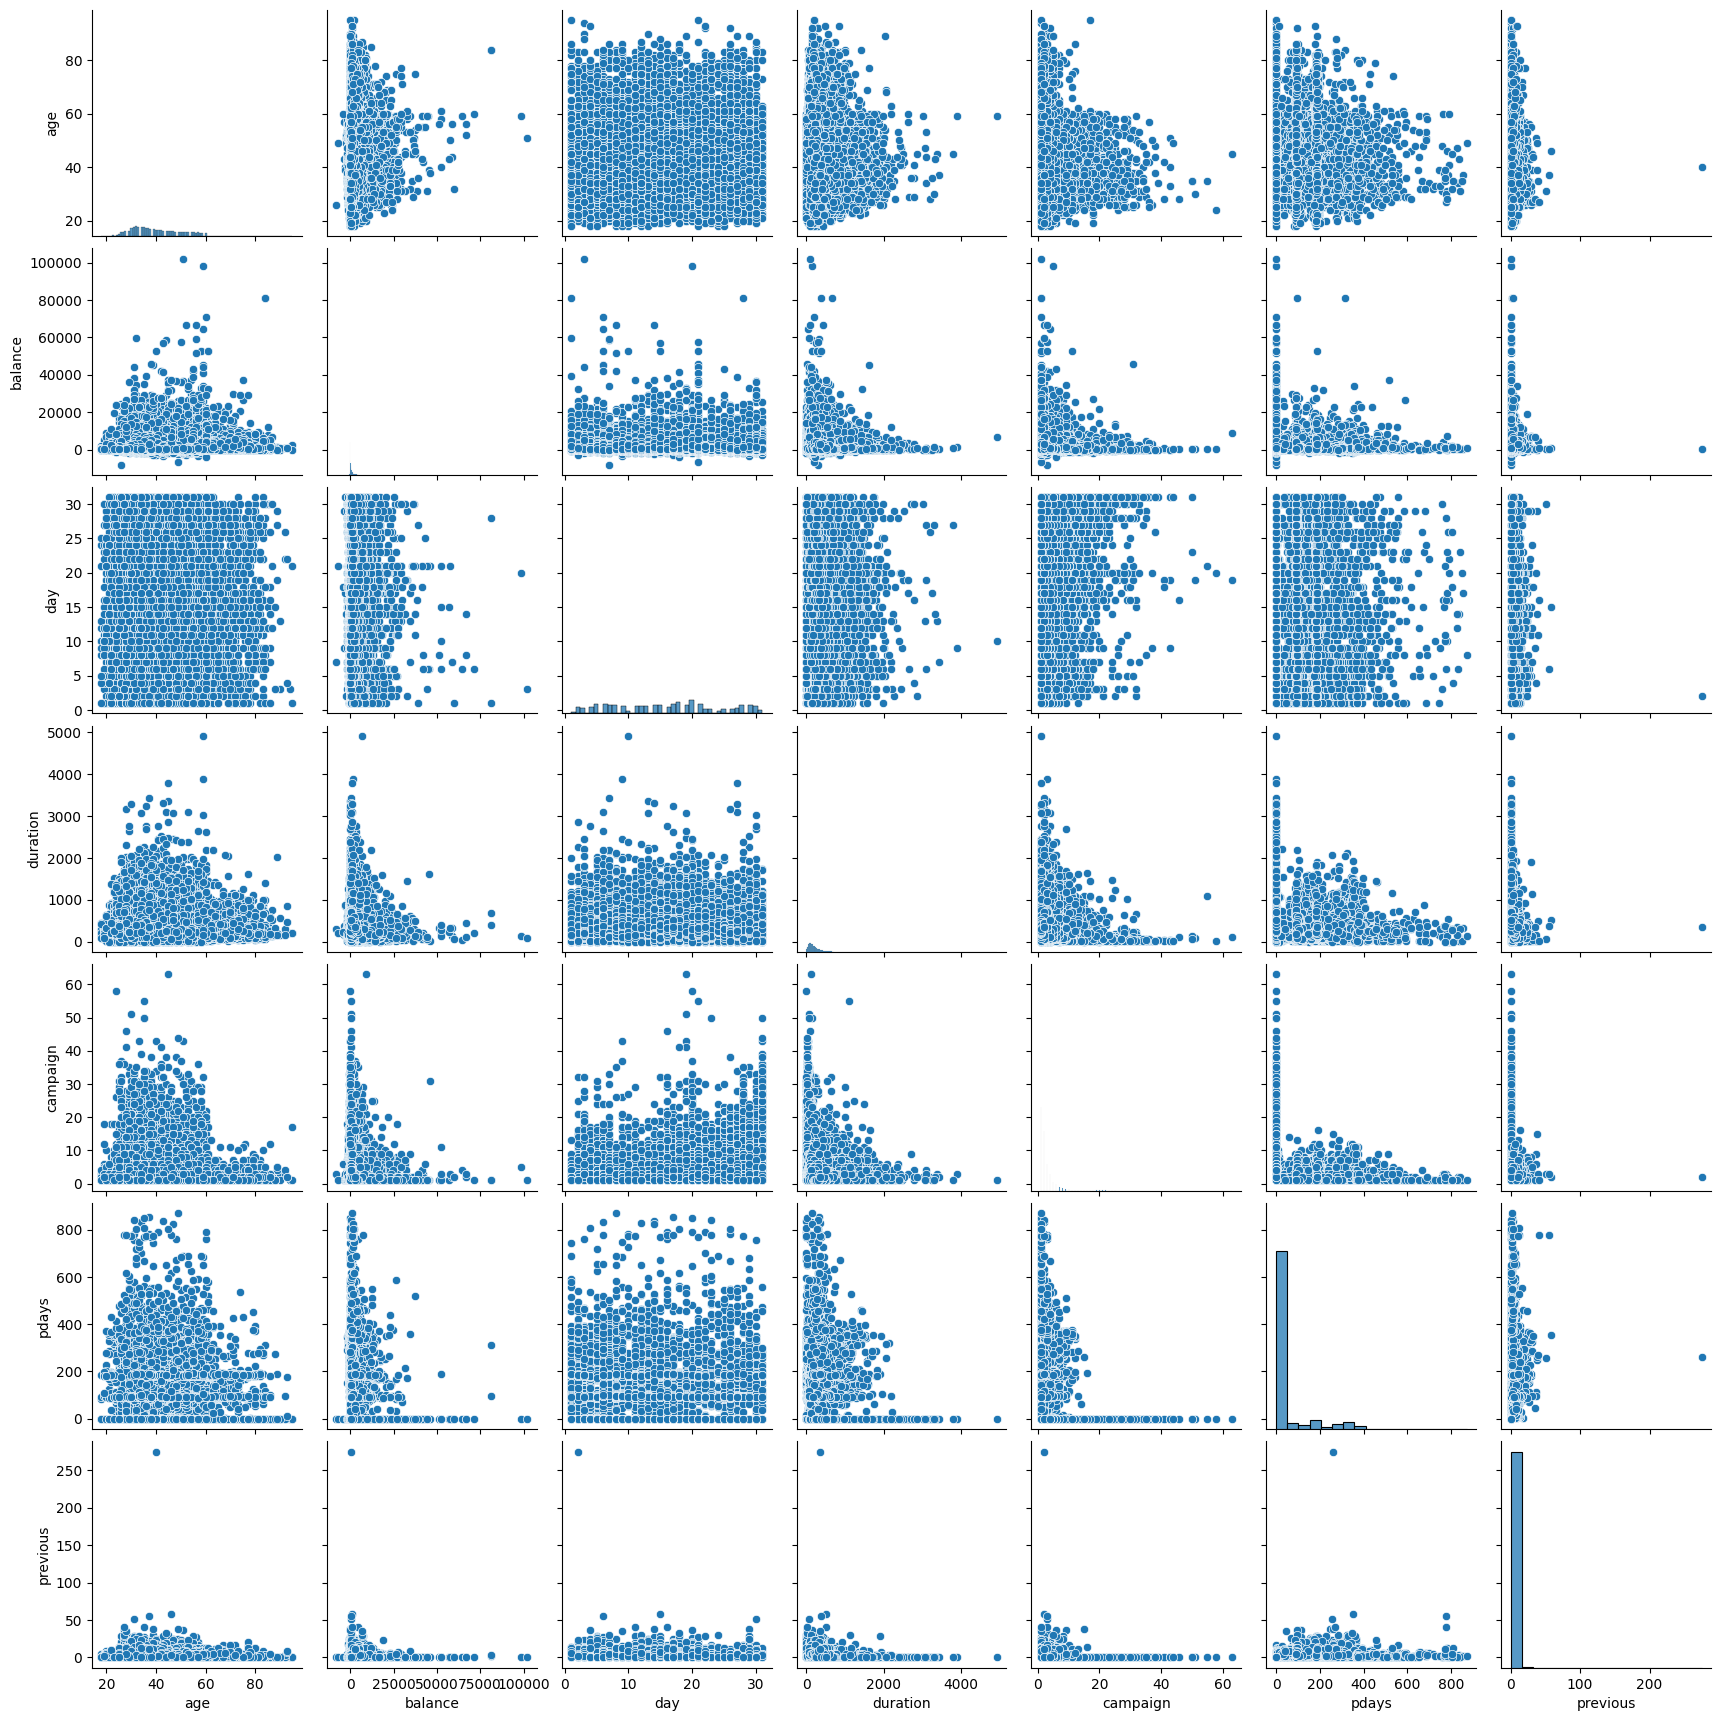

In [5]:
# Plot pair-wise relationships in the dataset
import seaborn as sns
sns.pairplot(df)

It looks like balance has a negative relationship with campaign and duration. Other than that, no significant deductions can be made.

<Axes: xlabel='duration', ylabel='balance'>

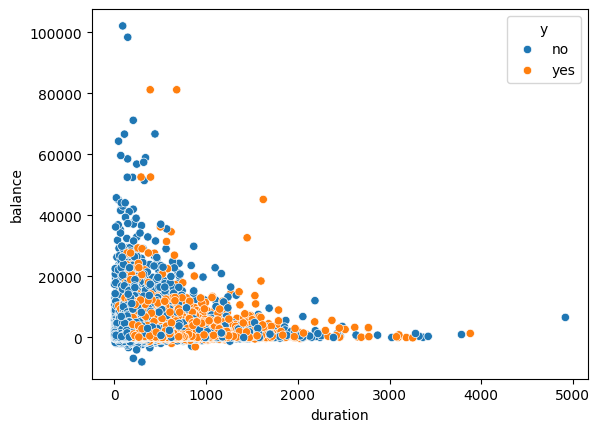

In [7]:
# 3D Scatter plot with hue
sns.scatterplot(x=df['duration'], y=df['balance'], hue=df['y'])

The orange dots (data points labeled 'yes') are clustered to right bottom. This means that individuals accepting to subscribe to a term deposit have lower balance levels as the longer time passes since they were last contacted.

## Predict Acceptance of Term Deposit

We'll fit classification models since the target variable y consists of binary values of 'yes' and 'no'.

### Logistic Regression

In [15]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,9,1,2,0,825,0,0,0,17,9,977,3,-1,0,3,1
45207,71,5,0,0,0,1729,0,0,0,17,9,456,2,-1,0,3,1
45208,72,5,1,1,0,5715,0,0,0,17,9,1127,5,184,3,2,1
45209,57,1,1,1,0,668,0,0,1,17,9,508,4,-1,0,3,0


In [14]:
# Scale data to eliminate the effect of feature units (especially for gradient descent cases)
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder

cols_cat = [col for col in df.columns if df[col].dtype == 'object']

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in cols_cat:
    df[col] = label_encoder.fit_transform(df[col])
y = df['y']
X = scale(df.drop(['y'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8, test_size=0.2,random_state=1)

In [17]:
# Build Logistic Regression model
from sklearn.linear_model import LogisticRegression


mdlLgr = LogisticRegression(random_state=1)
mdlLgr.fit(X_train, y_train)
y_test_pred = mdlLgr.predict(X_test)

We'll draw out a confusion matrix because since the target variable is binary (not linear), we can't directly calculate the error.

In [18]:
# Display model results using
from sklearn.metrics import confusion_matrix

print ('Confusion Matrix:')
print (confusion_matrix(y_test, y_test_pred))

Confusion Matrix:
[[7837  156]
 [ 830  220]]


## Metric 1: F1-score
The F1-score is simply the harmonic mean of the precision and recall

In [19]:
# Display performance results
from sklearn.metrics import classification_report

print ('Classification Report (Logistic Regression):')
print (classification_report(y_test, y_test_pred))

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7993
           1       0.59      0.21      0.31      1050

    accuracy                           0.89      9043
   macro avg       0.74      0.60      0.62      9043
weighted avg       0.87      0.89      0.87      9043



In [20]:
print('# of y variables that have value 0: ',df[df['y'] == 0].shape[0])
print('# of y variables that have value 1: ',df[df['y'] == 1].shape[0])


# of y variables that have value 0:  39922
# of y variables that have value 1:  5289


The failure in accurately classifying data points whose y values = 1 can be attributed to the unbalanced nature of the dataset. As it can be seen, data points that have a label of 1 are almost 1/8th of the entire dataset. Hence the model expectedly does a worse job at predicting those values.

In [21]:
# Display summary results
from sklearn.metrics import roc_auc_score

print ('AUC Score (Logistic Regression):')
print (roc_auc_score(y_test, y_test_pred))

AUC Score (Logistic Regression):
0.5950033660405235


AUC score is 59%, meaning that the model does almost nothing (it was going to be random if it was 50%, which would mean the model does nothing). We'll try to improve on this model.

utexas_ds_orie_divider_gray.png

### Naive Bayes
Naive Bayes is a probabilistic model that uses Bayes Theorem to predict probability of target value given features based on the probability of features given the target.

#### Naive Bayes - Gaussian
There were a couple of cells in the pairplot showcasing a distribution similar to that of a Gaussian distribution.

In [25]:
# Build Naive Bayes - Gaussian model
from sklearn.naive_bayes import GaussianNB

mdlNbg = GaussianNB()
mdlNbg.fit(X_train,y_train)
y_test_pred = mdlNbg.predict(X_test)

print ('Results (Naive Bayes - Gaussian):\n')

print ('Classification Report:')
print (classification_report(y_test, y_test_pred))

print ('AUC Score:')
print (roc_auc_score(y_test, y_test_pred))

Results (Naive Bayes - Gaussian):

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      7993
           1       0.35      0.49      0.40      1050

    accuracy                           0.83      9043
   macro avg       0.64      0.68      0.65      9043
weighted avg       0.86      0.83      0.85      9043

AUC Score:
0.6827803494724551


The AUC score improved significantly. I conclude that features are independent of each other mostly, based on the fact that naive bayes performed better than logistic regression and also from the inconclusiveness of the pairplot.

### K-Nearest Neighbor (KNN)
This is yet another way of getting to a similar outcome, but this time using cartesian distances to determine how close or far a new data point is to the previous data points.

In [23]:
# Build KNN model with 5 nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

mdlKnn = KNeighborsClassifier(n_neighbors=10)
mdlKnn.fit(X_train, y_train)
y_test_pred = mdlKnn.predict(X_test)

print ('AUC Score (K-Nearest Neighbor):')
print (roc_auc_score(y_test, y_test_pred))

AUC Score (K-Nearest Neighbor):
0.6071200395584232


As expected, we got a lower AUC score because the dataset was unbalanced; which as we have seen in class, is known to throw off KNN models.

### Support Vector Machines
While Logistic Regression and Naive Bayes are probabilistic models, Support Vector Machines try to create a boundary that maximize the margin between the different classes.

In [24]:
# Build Support Vector Machines - Classifier model

from sklearn.svm import SVC

mdlSvm = SVC()
mdlSvm.fit(X_train, y_train)
y_test_pred = mdlSvm.predict(X_test)

print ('Results (Support Vector Classifier):\n')

print ('Classification Report:')
print (classification_report(y_test, y_test_pred))

print ('AUC Score:')
print (roc_auc_score(y_test, y_test_pred))

Results (Support Vector Classifier):

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7993
           1       0.67      0.27      0.38      1050

    accuracy                           0.90      9043
   macro avg       0.79      0.62      0.66      9043
weighted avg       0.88      0.90      0.88      9043

AUC Score:
0.6247007798490346


Based on all the above models, it seems like naive bayes gives us the best results with an AUC score of 68%.  

## Conclusion

* We first observed the pairwise plot among all features to see if we can deduce any relationship between features. Other than duration and balance, we didn't manage to reach any conclusions regarding correlation.
* Afterwards, we did label encoding on categorical variables to include them in the model.
* Next, we fitted a logistic regression model. Since the target variable y had binary values; the models we used previously on continuous data were not applicable. However logistic regression did not result in the most desirable outcome as it provided a low AUC score, indicating the lack of significance the model brought to accurate prediction. We also found out that the dataset was unbalanced in target variable classes, which accounts for some of the inaccuracies we faced. Since there were not a significant relationship between features, the low score logistic regression provided was expected. Next, Naive Bayes was fitted due to its effectiveness in datasets consisting of independent features.
* Naive Bayes resulted in the best AUC score among all the models fitted, as it was proved after fitting KNN and SVM models.
* The resulting AUC is still not very desirable, indicating that there may be more complex relationships that cannot be captured with the models that we experimented with. Yet it's important to note that the unbalanced nature of the dataset may be accounting for this.

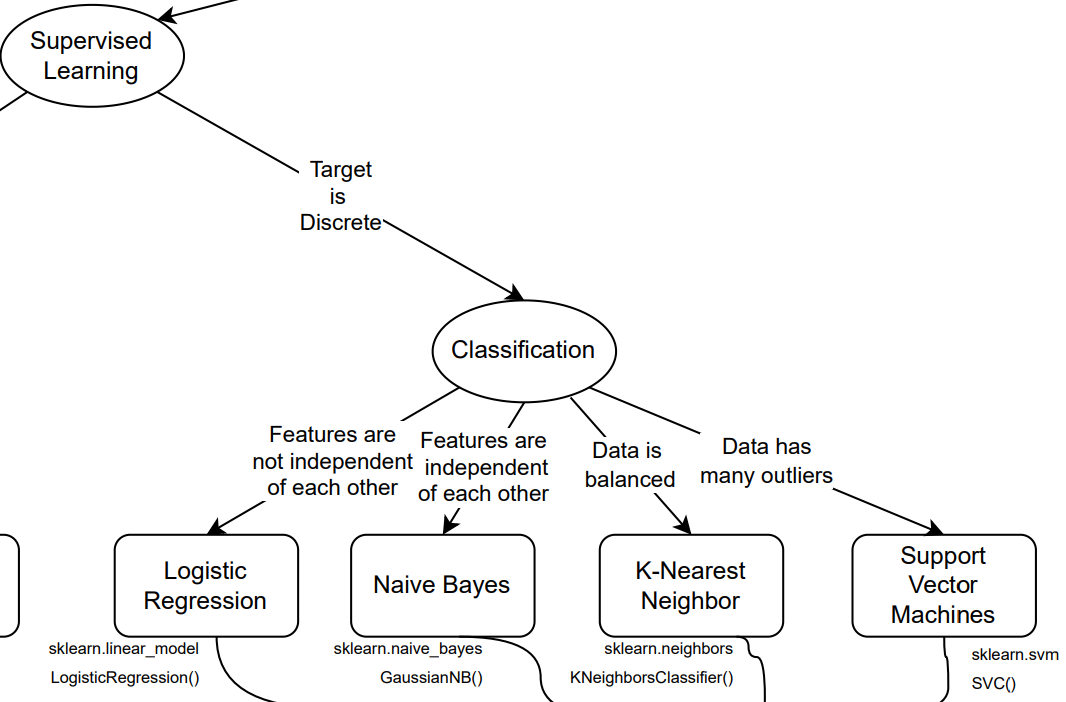